# Load Data

In [46]:
%load_ext autoreload
%autoreload 2
from load import load_3D
from liftpose.vision_3d import XY_coord, Z_coord
import yaml
import logging
from imp import reload
import torch
import numpy as np
import matplotlib.pyplot as plt
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

par = yaml.full_load(open('param.yaml', "rb"))

train, train_keypts, _ = load_3D(par["data_dir"], subjects=par['train_subjects'], actions=par['actions'] )
test,  test_keypts, _ = load_3D( par["data_dir"], subjects=par['test_subjects'],  actions=par['actions'] )
#project data to ventral view
train_2d, train_3d = XY_coord(train), Z_coord(train)
test_2d, test_3d  = XY_coord(test), Z_coord(test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [47]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d=train_2d, test_2d=test_2d, train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts, test_keypts=test_keypts, 
           roots=par['roots'], target_sets=par['targets'], in_dim=2, 
           out_dim=par["out_dim"], out_dir=par['out_dir'])

[main.py:84]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/fly_prism_package/out/stat_2d.pth.tar.
[main.py:108]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/fly_prism_package/out/stat_3d.pth.tar.
[main.py:153]:INFO:Starting training model
[main.py:162]:DEBUG:
==================Options=================
[main.py:163]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/fly_prism_package/out',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 100000,
    'lr_gamma': 0.96,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/fly_prism_package/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/fly_prism_package/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:164]:DEB

Epoch 0 | Loss Test 0 | Loss Train 1.3742|: 100%|██████████| 161/161 [00:02<00:00, 65.90it/s]
Epoch 1 | Loss Test 1.0048 | Loss Train 0.43296|: 100%|██████████| 161/161 [00:02<00:00, 69.39it/s]
Epoch 2 | Loss Test 0.86666 | Loss Train 0.16147|: 100%|██████████| 161/161 [00:02<00:00, 67.28it/s]
Epoch 3 | Loss Test 0.84782 | Loss Train 0.073561|: 100%|██████████| 161/161 [00:01<00:00, 83.99it/s] 
Epoch 4 | Loss Test 0.7107 | Loss Train 0.042193|: 100%|██████████| 161/161 [00:02<00:00, 70.03it/s]
Epoch 5 | Loss Test 0.69891 | Loss Train 0.031459|: 100%|██████████| 161/161 [00:02<00:00, 70.75it/s]
Epoch 6 | Loss Test 0.68493 | Loss Train 0.026583|: 100%|██████████| 161/161 [00:02<00:00, 69.36it/s]
Epoch 7 | Loss Test 0.65824 | Loss Train 0.024627|: 100%|██████████| 161/161 [00:02<00:00, 65.88it/s]
Epoch 8 | Loss Test 0.69231 | Loss Train 0.023674|: 100%|██████████| 161/161 [00:02<00:00, 63.15it/s]
Epoch 9 | Loss Test 0.67967 | Loss Train 0.023089|: 100%|██████████| 161/161 [00:02<00:00, 77

[pyplot.py:225]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


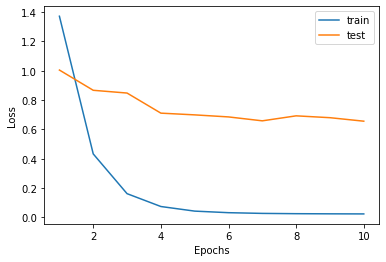

In [60]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [49]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:169]:INFO:starting testing in path: ./out/
[lift.py:54]:INFO:total params: 4.28M
[lift.py:60]:INFO:loading ckpt from './out//ckpt_best.pth.tar'
[lift.py:68]:INFO:ckpt loaded (epoch: 7 | err: 2.0584967136383057)
[lift.py:106]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/fly_prism_package/out/test_results.pth.tar


# Visualize Predictions

In [50]:
from liftpose.postprocess import load_test_results
test_3d, test_3d_pred = load_test_results(par['out_dir'])

In [55]:
import numpy as np
#from liftpose.utils import *
from liftpose.preprocess import *
legtips = [4, 9, 14, 19, 24, 29]
data = torch.load(par["out_dir"] + '/test_results.pth.tar')

tar_mean = torch.load(par["out_dir"] + '/stat_3d.pth.tar')['mean']
tar_std = torch.load(par["out_dir"] + '/stat_3d.pth.tar')['std']
targets_1d = torch.load(par["out_dir"] + '/stat_3d.pth.tar')['targets_3d']
tar_offset = np.vstack(torch.load(par["out_dir"] + '/stat_3d.pth.tar')['offset'].values())

inp_mean = torch.load(par["out_dir"] + '/stat_2d.pth.tar')['mean']
inp_std = torch.load(par["out_dir"] + '/stat_2d.pth.tar')['std']
targets_2d = torch.load(par["out_dir"] + '/stat_2d.pth.tar')['targets_2d']
inp_offset = np.vstack(torch.load(par["out_dir"] + '/stat_2d.pth.tar')['offset'].values())[0,:]


# TODO can adam explain this?
good_keypts = add_roots(data['good_keypts'],targets_1d,len(tar_mean))
if np.sum(good_keypts[0,:15])>10:
    tar_offset = np.hstack((tar_offset[0,:15],tar_offset[0,:15]))
else:
    tar_offset = np.hstack((tar_offset[0,15:],tar_offset[0,15:]))

#unnormalize
tar = unNormalize(data['target'], tar_mean[targets_1d], tar_std[targets_1d])
tar = add_roots(tar,targets_1d,len(tar_mean))
tar += tar_offset
out = unNormalize(data['output'], tar_mean[targets_1d], tar_std[targets_1d])
out = add_roots(out,targets_1d,len(tar_mean))
out += tar_offset
inp = unNormalize(data['input'], inp_mean[targets_2d], inp_std[targets_2d])
inp = add_roots(inp,targets_2d,len(inp_mean))
inp += inp_offset

/home/user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/home/user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


In [87]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from liftpose.plot import plot_pose_3d, plot_3d_graph

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=200, azim=60)

t = 1000
plt.cla()
        
thist = 5
pos_pred, pos_tar = [], []
for j in range(out.shape[1]):
    tmin = max(0,t-thist+1)
    pos_pred.append((inp[tmin:(t+1), 2*j], inp[tmin:(t+1), 2*j+1], -out[tmin:(t+1), j]))
    pos_tar.append((inp[tmin:(t+1), 2*j], inp[tmin:(t+1), 2*j+1], -tar[tmin:(t+1), j]))

pos_pred, pos_tar = np.array(pos_pred), np.array(pos_tar)

import networkx
G = nx.Graph()
G.add_edges_from(par["vis"]["bones"])
G.add_nodes_from(np.arange(par["ndims"]))

limb_id = [i for i in range(6) for j in range(5)]
edge_colors = [[x / 255.0 for x in par["vis"]["colors"][i]] for i in limb_id]

plot_3d_graph(G, pos_tar[:,:,-1], ax, color_edge=edge_colors, good_keypts=good_keypts[t,:])    
plot_3d_graph(G, pos_pred[:,:,-1], ax, color_edge=edge_colors, style='--') 

[pyplot.py:225]:DEBUG:Loaded backend module://ipympl.backend_nbagg version unknown.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …